This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 1s 0us/step
Epoch 1/5
938/938 [==============================] - 18s 4ms/step - loss: 0.1559 - accuracy: 0.9515
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0448 - accuracy: 0.9860
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0309 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0234 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0177 - accuracy: 0.9945


**Evaluating the convnet**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0348 - accuracy: 0.9899
Test accuracy: 0.990


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kellykimhuiyeong","key":"b1f5b9d19a72e8bb929f0aea546ccc4e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:02<00:00, 320MB/s]
100% 812M/812M [00:02<00:00, 293MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!ls

dogs-vs-cats.zip  sample_data		test1.zip
kaggle.json	  sampleSubmission.csv	train.zip


In [ ]:
!unzip -qq train.zip

In [ ]:
os.listdir('train')

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
dir = new_base_dir / 'train' / 'cat'

In [ ]:
dir

PosixPath('cats_vs_dogs_small/train/cat')

In [ ]:
fnames = [f"{'dog'}.{i}.jpg" for i in range(0, 1000)]

In [ ]:
fnames

In [ ]:
os.listdir('cats_vs_dogs_small/test/dog')

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4))).batch(32)
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 4, 4)
(32, 4, 4)
(32, 4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [64]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 78ms/step - loss: 0.7967 - accuracy: 0.5070 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6988 - accuracy: 0.5410 - val_loss: 0.6936 - val_accuracy: 0.5040
Epoch 3/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6709 - accuracy: 0.5980 - val_loss: 1.8928 - val_accuracy: 0.5080
Epoch 4/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6290 - accuracy: 0.6810 - val_loss: 0.8525 - val_accuracy: 0.5380
Epoch 5/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6028 - accuracy: 0.6820 - val_loss: 0.8323 - val_accuracy: 0.5760
Epoch 6/30
63/63 [==============================] - 4s 67ms/step - loss: 0.5397 - accuracy: 0.7375 - val_loss: 0.6543 - val_accuracy: 0.6820
Epoch 7/30
63/63 [==============================] - 4s 67ms/step - loss: 0.4975 - accuracy: 0.7620 - val_loss: 0.6213 - val_accuracy: 0.7080
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

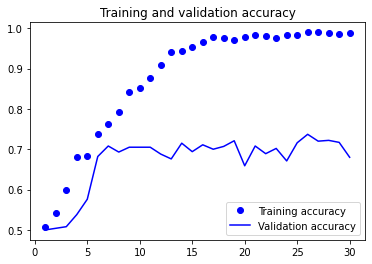

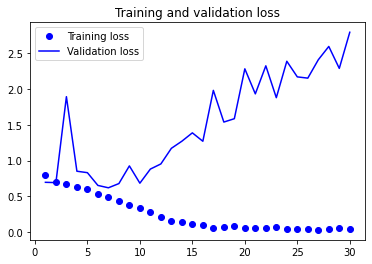

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.6326 - accuracy: 0.6875
Test accuracy: 0.688


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [57]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

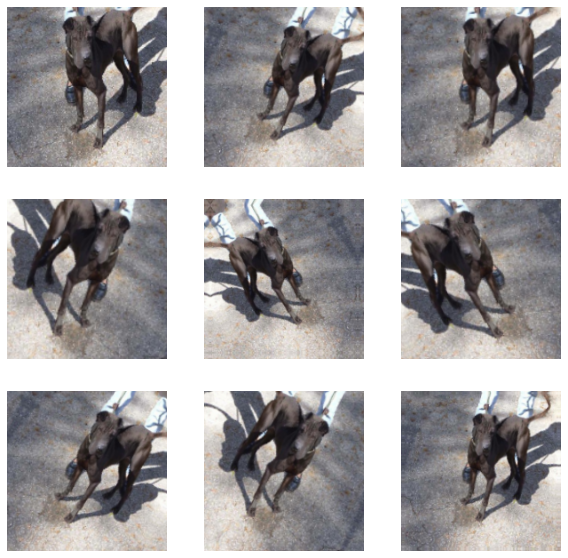

In [58]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [59]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)                                             ##change1
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)                                                ##change2
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 7s 87ms/step - loss: 0.7029 - accuracy: 0.5005 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6952 - accuracy: 0.5010 - val_loss: 0.6883 - val_accuracy: 0.5540
Epoch 3/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6913 - accuracy: 0.5510 - val_loss: 0.7094 - val_accuracy: 0.5310
Epoch 4/100
63/63 [==============================] - 5s 74ms/step - loss: 0.6752 - accuracy: 0.5925 - val_loss: 0.6633 - val_accuracy: 0.5860
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6635 - accuracy: 0.6345 - val_loss: 0.7522 - val_accuracy: 0.5950
Epoch 6/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6449 - accuracy: 0.6460 - val_loss: 0.7816 - val_accuracy: 0.5930
Epoch 7/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6363 - accuracy: 0.6510 - val_loss: 0.6192 - val_accuracy: 0.6440
Epoch 

**Evaluating the model on the test set**

In [61]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.4583 - accuracy: 0.8115
Test accuracy: 0.812


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [62]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [63]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [65]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [66]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 25.2482 - accuracy: 0.9200 - val_loss: 3.7301 - val_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 5.7510 - accuracy: 0.9690 - val_loss: 6.8725 - val_accuracy: 0.9610
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2.4071 - accuracy: 0.9845 - val_loss: 3.4355 - val_accuracy: 0.9780
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 0.4497 - accuracy: 0.9960 - val_loss: 3.2869 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9652 - accuracy: 0.9930 - val_loss: 3.8114 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4606 - accuracy: 0.9930 - val_loss: 4.4280 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2931 - accuracy: 0.9980 - val_loss: 4.4123 - val_accuracy: 0.9790
Epoch 8/20
63/63 [

**Plotting the results**

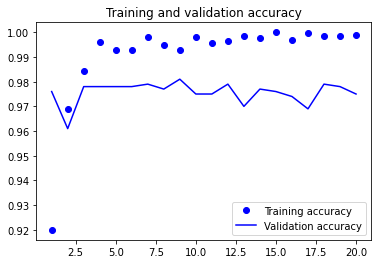

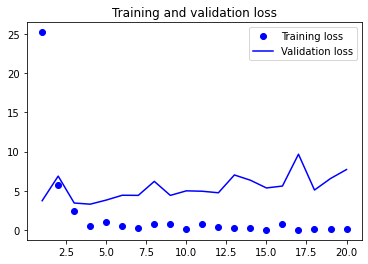

In [67]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [68]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [69]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [70]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [72]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 173ms/step - loss: 12.4117 - accuracy: 0.9060 - val_loss: 8.3883 - val_accuracy: 0.9420
Epoch 2/50
63/63 [==============================] - 11s 171ms/step - loss: 7.5608 - accuracy: 0.9460 - val_loss: 3.9699 - val_accuracy: 0.9690
Epoch 3/50
63/63 [==============================] - 11s 169ms/step - loss: 5.0487 - accuracy: 0.9545 - val_loss: 9.7437 - val_accuracy: 0.9500
Epoch 4/50
63/63 [==============================] - 11s 173ms/step - loss: 4.6569 - accuracy: 0.9615 - val_loss: 3.9302 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 11s 170ms/step - loss: 5.1371 - accuracy: 0.9590 - val_loss: 4.0994 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 11s 170ms/step - loss: 4.8605 - accuracy: 0.9620 - val_loss: 6.7539 - val_accuracy: 0.9590
Epoch 7/50
63/63 [==============================] - 11s 171ms/step - loss: 3.2185 - accuracy: 0.9725 - val_loss: 4.5521 - val_accuracy: 0.974

**Evaluating the model on the test set**

In [73]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 105ms/step - loss: 1.7050 - accuracy: 0.9745
Test accuracy: 0.975


### Fine-tuning a pretrained model

In [74]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [75]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [77]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Fine-tuning the model**

In [76]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 191ms/step - loss: 0.5230 - accuracy: 0.9875 - val_loss: 2.1567 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 12s 188ms/step - loss: 0.4002 - accuracy: 0.9880 - val_loss: 2.1102 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 12s 187ms/step - loss: 0.3669 - accuracy: 0.9910 - val_loss: 1.5740 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 12s 184ms/step - loss: 0.2511 - accuracy: 0.9905 - val_loss: 1.7802 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 14s 219ms/step - loss: 0.2437 - accuracy: 0.9915 - val_loss: 1.4995 - val_accuracy: 0.9810
Epoch 6/30
63/63 [==============================] - 13s 192ms/step - loss: 0.2805 - accuracy: 0.9910 - val_loss: 1.7291 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 12s 187ms/step - loss: 0.2625 - accuracy: 0.9915 - val_loss: 1.7873 - val_accuracy: 0.9810

In [78]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 107ms/step - loss: 1.4958 - accuracy: 0.9770
Test accuracy: 0.977


## Summary